In [30]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("C:/Users/HP/OneDrive/Desktop/Casestudy_godrej.csv")



In [31]:
df.head()

,Date,Price
0,03-21-2024,"2,223.55"
1,03-20-2024,"2,139.90"
2,03-19-2024,"2,135.55"
3,03-18-2024,"2,162.95"
4,03-15-2024,"2,218.25"


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1487 non-null   object
 1   Price   1487 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [33]:
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%Y', errors='coerce')
# Remove commas from 'Price' column and convert to float
df['Price'] = df['Price'].str.replace(',', '').astype(float)
# Append the dates parsed with a different format


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1487 non-null   datetime64[ns]
 1   Price   1487 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.4 KB


In [35]:
na_count = df['Date'].isna().sum()

print("Number of NaT values:", na_count)

Number of NaT values: 0


In [36]:
df.sort_values('Date', inplace=True)
df

,Date,Price
1486,2018-03-22,738.45
1485,2018-03-23,725.60
1484,2018-03-26,730.95
1483,2018-03-27,725.60
1482,2018-03-28,722.90
...,...,...
4,2024-03-15,2218.25
3,2024-03-18,2162.95
2,2024-03-19,2135.55
1,2024-03-20,2139.90


Epoch 1/100
37/37 - 7s - loss: 0.0556 - val_loss: 0.0191 - 7s/epoch - 177ms/step
Epoch 2/100
37/37 - 1s - loss: 0.0086 - val_loss: 0.0048 - 1s/epoch - 36ms/step
Epoch 3/100
37/37 - 1s - loss: 0.0072 - val_loss: 0.0030 - 1s/epoch - 35ms/step
Epoch 4/100
37/37 - 1s - loss: 0.0052 - val_loss: 0.0022 - 1s/epoch - 36ms/step
Epoch 5/100
37/37 - 1s - loss: 0.0055 - val_loss: 0.0060 - 1s/epoch - 36ms/step
Epoch 6/100
37/37 - 1s - loss: 0.0049 - val_loss: 0.0040 - 1s/epoch - 36ms/step
Epoch 7/100
37/37 - 1s - loss: 0.0049 - val_loss: 0.0016 - 1s/epoch - 36ms/step
Epoch 8/100
37/37 - 1s - loss: 0.0046 - val_loss: 0.0020 - 1s/epoch - 35ms/step
Epoch 9/100
37/37 - 1s - loss: 0.0045 - val_loss: 0.0015 - 1s/epoch - 35ms/step
Epoch 10/100
37/37 - 1s - loss: 0.0042 - val_loss: 0.0022 - 1s/epoch - 36ms/step
Epoch 11/100
37/37 - 1s - loss: 0.0036 - val_loss: 0.0014 - 1s/epoch - 37ms/step
Epoch 12/100
37/37 - 1s - loss: 0.0034 - val_loss: 0.0027 - 1s/epoch - 36ms/step
Epoch 13/100
37/37 - 1s - loss: 0.00

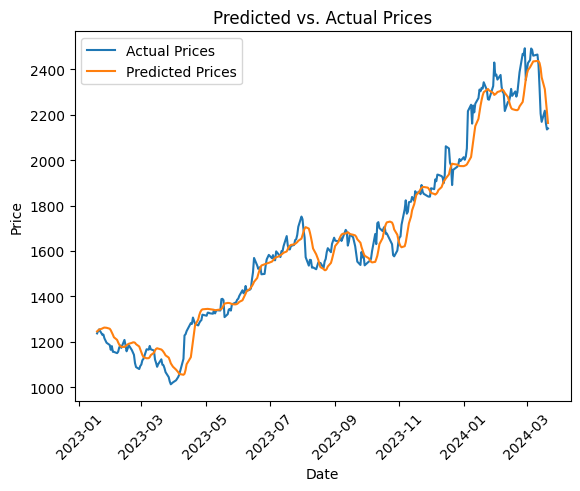

1/1 [==============================] - 0s 32ms/step
Predicted price for the next day: 2164.0242


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

# Extract only the 'Price' column
data = df['Price'].values.reshape(-1, 1)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Define the number of previous time steps to use for prediction
n_steps = 30  # You can adjust this value based on your dataset and requirements

# Prepare the data for the LSTM model
X, y = [], []
for i in range(len(data_normalized) - n_steps - 1):
    X.append(data_normalized[i:i+n_steps])
    y.append(data_normalized[i+n_steps])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split_index], X[split_index:], y[:split_index], y[split_index:]

# Build the LSTM model
model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping])

# Make predictions
predicted_normalized = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_normalized)

# Convert back to original scale
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_orig, predicted_prices))
print("Root Mean Squared Error (RMSE):", rmse)

# Visualize predictions vs. actual values
plt.plot(df['Date'][split_index+n_steps+1:], y_test_orig, label='Actual Prices')
plt.plot(df['Date'][split_index+n_steps+1:], predicted_prices, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs. Actual Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print the next day predicted value
next_day_pred_normalized = model.predict(X_test[-1:])
next_day_pred_price = scaler.inverse_transform(next_day_pred_normalized)
print("Predicted price for the next day:", next_day_pred_price[0][0])
